# 1. Introduction
This notebook is part of a machine learning for healthcare exercise, focusing on using the Responsible AI (RAI) package to enhance clinical decision-making. The toolkit will be used to analyze opioid use disorder (OD) risk, with three key objectives:

1. Analyze Errors and Explore Interpretability of Models: We will run Interpret-Community’s global explainers to generate feature importance insights and visualize model errors with the Error Analysis dashboard

2. Plan real-world action through counterfactual and causal analysis: By leveraging counterfactual examples and causal inference, we will explore decision-making strategies based on opioid prescription patterns and patient comorbidities to understand possible interventions and their impacts

3. Assess addiction risk predictions: A classification model trained on patient-level features (income, surgeries, opioid prescription days, and comorbidities A–V) will be evaluated to examine its performance in predicting risk of opioid use disorder and to inform prevention strategies

**The goal is to provide non-trivial insights for clinical decision making, leveraging machine learning paired with responsible AI tools, to improve patient outcomes in the healthcare context.**

Based on notebooks from the [Responsible AI toolkit](https://github.com/microsoft/responsible-ai-toolbox/tree/main/notebooks)


**CURRENT POTENTIAL HYPOTHESIS (S)**

--> If a patient is diagnosed with asthma, they would be diagnosed with lung cancer faster (due to more frequent checkups), leading to a higher chance of being diagnosed within stage 1 and 2 and therefore, a higher chance of survival. 

--> If a patient is diagnosed with cirrhosis, they will be less likely to survive if undergoing chemotherapy/radiation (as this would jeopordize the treatment). 

--> If a patient has smoked in the past to present, it will reduce a patients chances of surviving lung cancer. 


**WHAT WE ARE LOOKING FOR**
- biggest indicators of a patients survival or lack of. 

# 2. Data Set Characteristics

Number of Instances: patient-level records (rows)

Number of Attributes: 15 predictive attributes and 1 target class

Attribute Information:
- age: age of patient at time of diagnosis
- gender: male/female
- country: country where patient resides at time of diagnosis
- diagnosis_date: date of patients diagnosis (year-month-day)
- cancer_stage: stage of cancer at time of diagnosis (1,2,3,4)
- family_history: yes/no of a family history of cancer
- smoking_status: smoking status of patient (1: current smoker, 2: former smoker, 3: never smoked, 4: passive smoker)
- bmi: Body Mass Index of patient at time of diagnosis
- cholesterol_level: integer value of cholesterol_level
- hypertension: indicates if patient has high blood pressure (1: yes, 0: no)
- asthma: indicates if patient has asthma (1: yes, 0: no)
- cirrhosis: indicates if patient has cirrhosis (1: yes, 0: no)
- other_cancer: indicates if patient has another form of cancer, aside from original diagnosis (1: yes, 0: no)
- treatment_type: type of treatment patient received (1: surgery, 2: chemotherapy, 3: radiation, 4: combined)
- end_treatment_date: date on which patient completed their treatment or died
- survived (target): indicates if patient lived or died (1: yes, 0:no)


class:
- survived = 1: patient who survived cancer treatment 
- survived = 0: patient who died during cancer treatment (due to cancer)


# 3. Setup
- responsibleai and raiwidgets provide RAIInsights and the dashboard
- fairlearn provides fairness metrics and mitigation algorithms used under the hood
- imbalanced-learn offers resampling utilities if you want to experiment with imbalance mitigation

In [1]:
import numpy
import scipy
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)


NumPy: 1.26.2
SciPy: 1.15.3


In [2]:
# 1. Setup

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.display import display, Markdown
import opendatasets as od 
import seaborn as sns
from itertools import combinations 
from yellowbrick.features import Rank2D
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,           # Measures the ability of the model to distinguish between classes (higher is better)
    average_precision_score, # Computes the average precision for precision-recall curves (useful for imbalanced data)
    brier_score_loss,        # Measures the mean squared difference between predicted probabilities and actual outcomes (lower is better)
    log_loss,                # Penalizes false classifications with a focus on probability estimates (lower is better)
    confusion_matrix,        # Summarizes true/false positives/negatives for classification predictions
    precision_score,         # Proportion of positive identifications that were actually correct (TP / (TP + FP))
    recall_score,            # Proportion of actual positives that were correctly identified (TP / (TP + FN))
    RocCurveDisplay,         
    PrecisionRecallDisplay,
    f1_score,
    r2_score, 
    mean_squared_error,
    classification_report
)
# Fairness utilities
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
    )
    _FAIRLEARN = True
except Exception:
    _FAIRLEARN = False

# Responsible AI dashboard
try:
    from responsibleai import RAIInsights
    from raiwidgets import ResponsibleAIDashboard
    _RAI = True
except Exception:
    _RAI = False

# Course utilities for transparency and thresholding
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 4. Data Load & preparation

In [ ]:
# Path to your CSV (update if needed for your system)
DATA_PATH = "./Data/lung_cancer_dataset_med.csv"

# PATIENT DATASET - Lung Cancer data loaded
df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(15)    #example of dataset

Shape: (890000, 17)


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
5,6,50.0,Male,Italy,2023-01-02,Stage I,No,Never Smoked,37.6,274,1,0,0,0,Radiation,2024-12-27,0
6,7,49.0,Female,Croatia,2018-05-21,Stage III,Yes,Passive Smoker,43.1,259,0,0,0,0,Radiation,2019-05-06,1
7,8,51.0,Male,Denmark,2017-02-18,Stage IV,Yes,Former Smoker,25.8,195,1,1,0,0,Combined,2017-08-26,0
8,9,64.0,Male,Sweden,2021-03-21,Stage III,Yes,Current Smoker,21.5,236,0,0,0,0,Chemotherapy,2022-03-07,0
9,10,56.0,Male,Hungary,2021-11-30,Stage IV,Yes,Current Smoker,17.3,183,1,0,0,1,Surgery,2023-11-29,0


Further Elementary Analysis of LC Dataset (Complete Analysis done in the seperate EDA notebook).

In [ ]:
df_raw.describe()    

,id,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,445000.500000,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229
std,256921.014127,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401
min,1.000000,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222500.750000,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,445000.500000,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,667500.250000,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,890000.000000,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4.1. Basic cleaning and schema alignment

Here we prepare the patient dataset so the model can learn to predict if a patient will survive lung cancer or not. The steps are: 
- Define what we are predicting (TARGET= 'survival')
- Create a copy of the data to ensure the original data remains untouched.
- Handle the date data correctly, calculates how long treatment lasted (in days)
- Remove incorrect and partially missing data
- Standardize numerical data by scaling them the same (this helps models learn better). 
- Seperate the target ('survived') as y, and the features (all other data columns) as X
- Convert the other features into data the model can use and renames some of the columns for better readability. 
- Drop unncessary columns, clean up the column names, shows a final check of the dataset.

In [ ]:
TARGET = "survived"      # We predict a yes/no of a patient's survival

df = df_raw.copy()       # Make a copy of the data so the orignal data is preserved 

# Ensures the date data is converted to a usable type for our model
df["diagnosis_date"] = pd.to_datetime(df["diagnosis_date"], errors="coerce")
df["end_treatment_date"] = pd.to_datetime(df["end_treatment_date"], errors="coerce")
df["treatment_duration_days"] = (df["end_treatment_date"] - df["diagnosis_date"]).dt.days

#Drop invalid/negative durations
df = df[df["treatment_duration_days"].notna()]
df = df[df["treatment_duration_days"] >= 0]

num_cols = ['age', 'bmi', 'cholesterol_level', 'treatment_duration_days']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print(df.head())


#drop raw/date columns
y = df[TARGET]
X = df

#column groups
cat_cols = ['gender','family_history', 'smoking_status', 'treatment_type']
binary_cols = ['hypertension', 'cirrhosis', 'asthma']

corr = X.corr(numeric_only=True)
print(corr)


#Stage ordinal
stage_map = {"Stage I":1,
             "Stage II":2,
             "Stage III":3,
             "Stage IV":4}
X["cancer_stage"] = X["cancer_stage"].map(stage_map)


# one hot encoded 
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

X.rename(columns={
    'smoking_status_Current Smoker': 'smoker_current',
    'smoking_status_Former Smoker': 'smoker_former',
    'smoking_status_Never Smoked': 'smoker_never',
    'smoking_status_Passive Smoker': 'smoker_passive',
    "treatment_type_Chemotherapy":"treat_chemo",
    "treatment_type_Combined":"treat_combined",
    "treatment_type_Radiation":"treat_radiation",
    "treatment_type_Surgery":"treat_surgery"
}, inplace=True)



X = X.drop(["id", "diagnosis_date","end_treatment_date","survived", "country"], axis=1)
print(X.head(10))

X.columns = [c.strip().replace(" ", "_").replace("-", "_")
              for c in X.columns]

print("Columns in X:", X.columns.tolist())
# assert "survived" not in X.columns
assert "id" not in X.columns



   id       age  gender      country diagnosis_date cancer_stage  \
0   1  0.899796    Male       Sweden     2016-04-05      Stage I   
1   2 -0.500977  Female  Netherlands     2023-04-20    Stage III   
2   3  0.999851  Female      Hungary     2023-04-05    Stage III   
3   4 -0.400922  Female      Belgium     2016-02-05      Stage I   
4   5 -1.801696    Male   Luxembourg     2023-11-29      Stage I   

  family_history  smoking_status       bmi  cholesterol_level  hypertension  \
0            Yes  Passive Smoker -0.130748          -0.797424             0   
1            Yes  Passive Smoker  1.279296           1.067550             1   
2            Yes   Former Smoker  1.613882           0.791257             1   
3             No  Passive Smoker  1.494387           0.169599             1   
4             No  Passive Smoker -1.289852          -1.280936             0   

   asthma  cirrhosis  other_cancer treatment_type end_treatment_date  \
0       0          1             0   Chemoth

**Correlation Heatmap**

Here we provide a graph (heatmap) that shows how strongly different features are related to each other. 
- A high, positive value (closer to 1) means that two factors will increase together (are correlated).
- A high, negative value (closer to -1) means that one factor will decrease while the other increases (are not correlated).

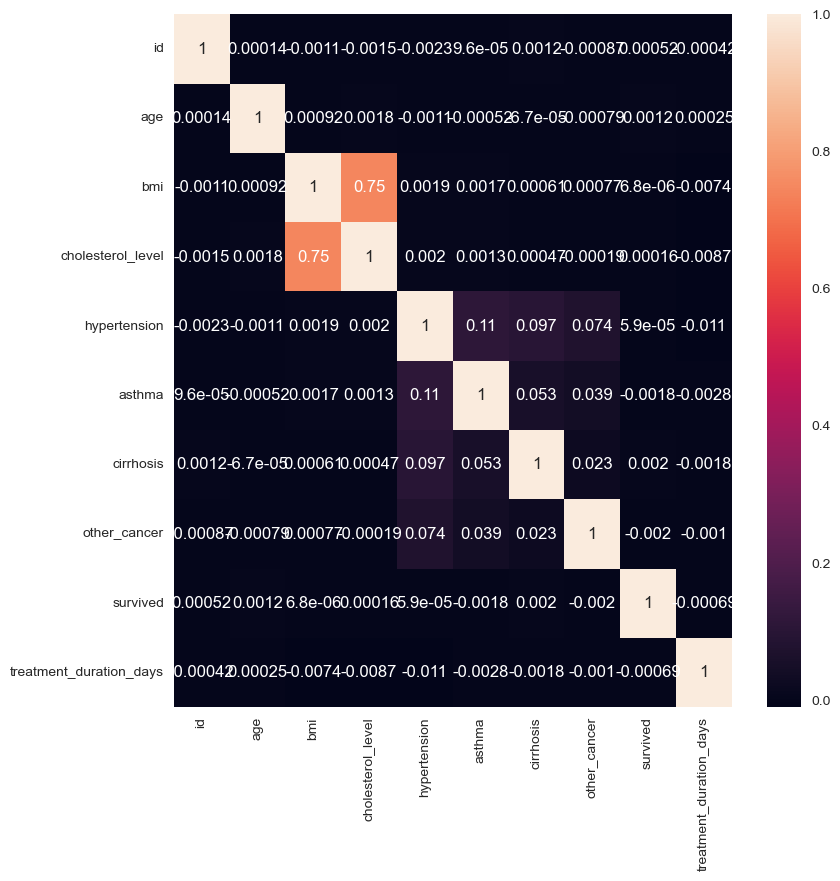

In [6]:
plt.figure(figsize=(9,9))
sns.heatmap(corr, annot=True)
plt.show()

Final check of the basic information (remaining columns and their data types) of X.

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890000 entries, 0 to 889999
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      890000 non-null  float64
 1   cancer_stage             890000 non-null  int64  
 2   bmi                      890000 non-null  float64
 3   cholesterol_level        890000 non-null  float64
 4   hypertension             890000 non-null  int64  
 5   asthma                   890000 non-null  int64  
 6   cirrhosis                890000 non-null  int64  
 7   other_cancer             890000 non-null  int64  
 8   treatment_duration_days  890000 non-null  float64
 9   gender_Female            890000 non-null  uint8  
 10  gender_Male              890000 non-null  uint8  
 11  family_history_No        890000 non-null  uint8  
 12  family_history_Yes       890000 non-null  uint8  
 13  smoker_current           890000 non-null  uint8  
 14  smok

Example of final results of X.

In [8]:
X.head()

,age,cancer_stage,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_duration_days,gender_Female,...,family_history_No,family_history_Yes,smoker_current,smoker_former,smoker_never,smoker_passive,treat_chemo,treat_combined,treat_radiation,treat_surgery
0,0.899796,1,-0.130748,-0.797424,0,0,1,0,0.465906,0,...,0,1,0,0,0,1,1,0,0,0
1,-0.500977,3,1.279296,1.067550,1,1,0,0,-0.244658,1,...,0,1,0,0,0,1,0,0,0,1
2,0.999851,3,1.613882,0.791257,1,1,0,0,-0.632238,1,...,0,1,0,1,0,0,0,1,0,0
3,-0.400922,1,1.494387,0.169599,1,1,0,0,-0.108287,1,...,1,0,0,0,0,1,1,0,0,0
4,-1.801696,1,-1.289852,-1.280936,0,0,0,0,-0.373851,0,...,1,0,0,0,0,1,0,1,0,0


### 4.1 Feature Engineering (takeaways from EDA notebook)

In [9]:
# #treatment x cancer_stage 
# for t in ["treat_surgery"]:
#     X[f"{t}_stage"] = X[t] * X["cancer_stage"]   

#comorbidities x treatment as this can change toleration to chemo/radiation
# for t in ["treat_chemo","treat_surgery","treat_radiation"]:
#     X[f"{t}_comorbid"] = X[t]*X["comorbidities"]   

# #smoked x treatment_type as it could have differnt outcomes with chemo/radiation
# for t in ["treat_chemo", "treat_radiation"]:
#     X[f"{t}_smoked"] = X[t] * X["smoked"]


Upon futher evaluation, these engineered features did not add anything of value to our model so we simplified it down in order to improve performance. 

# 5. Training, Validation and Testing - 80/15/5 stratified split

Train–test-val split

- Prevents “peeking” at data and overestimating performance
- Mimics real-world deployment where models face unseen patients
- Always evaluate on data not used for training

Training set (80%): used by model to learn patterns in the majority of the data
Validation set (15%): used by model to tun/test performance while training
Test set (5%): Used at the end to see how model performs (tests) on new data being introduced. 

In [ ]:
# y=1 means patient SURVIVED (positive outcome)
# y=0 means patient DIED (negative outcome)
# Note: High predicted probability = High survival chance = Good outcome
y = df[TARGET].copy()

print(f"Features in X: {X.columns.tolist()}")
print(f"Number of features: {X.shape[1]}")
print(f"\nTarget distribution (y=1 means SURVIVED, y=0 means DIED):")
print(f"  Survived (y=1): {y.sum()} ({100*y.mean():.1f}%)")
print(f"  Died (y=0): {(1-y).sum()} ({100*(1-y.mean()):.1f}%)")

# 80% train, 20% temp (which splits into 15% validation + 5% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Split temp into validation (15% of total) and test (5% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)


# Display shapes and class distributions as a DataFrame
info = {
    "Set": ["Train", "Validation", "Test", "Overall"],
    "X shape": [X_train.shape, X_val.shape, X_test.shape, X.shape],
    "y shape": [y_train.shape, y_val.shape, y_test.shape, y.shape],
    "p(survived=0)": [
        y_train.value_counts(normalize=True).get(0, 0.0),
        y_val.value_counts(normalize=True).get(0, 0.0),
        y_test.value_counts(normalize=True).get(0, 0.0),
        y.value_counts(normalize=True).get(0, 0.0),
    ],
    "p(survived=1)": [
        y_train.value_counts(normalize=True).get(1, 0.0),
        y_val.value_counts(normalize=True).get(1, 0.0),
        y_test.value_counts(normalize=True).get(1, 0.0),
        y.value_counts(normalize=True).get(1, 0.0),
    ],
}

df_info = pd.DataFrame(info)
display(df_info.style.format({"p(survived=0)": "{:.3f}", "p(survived=1)": "{:.3f}"}))

Features in X: ['age', 'cancer_stage', 'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_duration_days', 'gender_Female', 'gender_Male', 'family_history_No', 'family_history_Yes', 'smoker_current', 'smoker_former', 'smoker_never', 'smoker_passive', 'treat_chemo', 'treat_combined', 'treat_radiation', 'treat_surgery']
Number of features: 21

Target distribution (y=1 means SURVIVED, y=0 means DIED):
  Survived (y=1): 196004 (22.0%)
  Died (y=0): 693996 (78.0%)


,Set,X shape,y shape,p(survived=0),p(survived=1)
0,Train,"(712000, 21)","(712000,)",0.780,0.220
1,Validation,"(133500, 21)","(133500,)",0.780,0.220
2,Test,"(44500, 21)","(44500,)",0.780,0.220
3,Overall,"(890000, 21)","(890000,)",0.780,0.220


## 5.1. Modeling pipeline, training, and calibration

### Setting a baseline
A naive majority-class baseline clarifies the minimum standard any model must beat, highlighting the danger of ignoring minority patients and ensuring improvements carry meaningful weight in healthcare decision making

**ROC AUC**  
- 0.5 → no discrimination
- 0.6–0.7 → poor
- 0.7–0.8 → fair
- 0.8–0.9 → good
- ≥ 0.9 → excellent

**PR AUC**  
- Must be interpreted against event prevalence `p` in the validation set  

Dummy baseline
PR AUC: 0.220
ROC AUC: 0.500
Prevalence p = 0.220  |  PR AUC lift = 1.00× over baseline


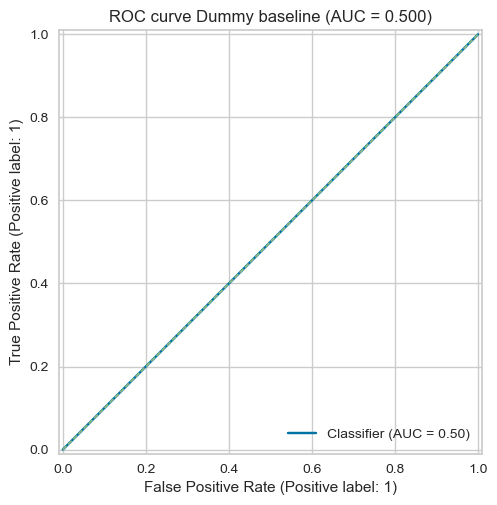

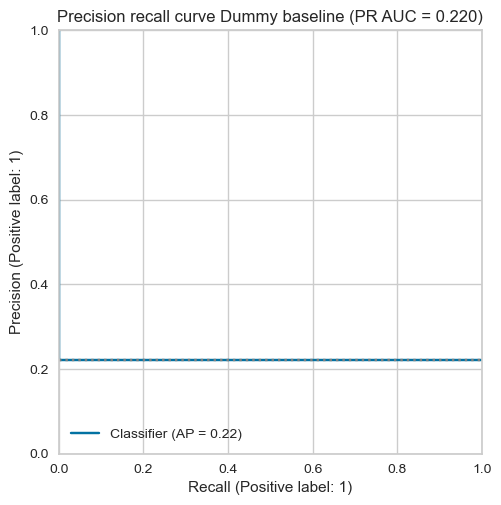

In [12]:
# Baseline: DummyClassifier (majority class)
dummy_clf = DummyClassifier(
    strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

proba_val = dummy_clf.predict_proba(X_val)
pos_idx = int(np.where(dummy_clf.classes_ == 1)[0][0])  # index for class "1"
y_score_val = np.asarray(proba_val)[:, pos_idx]

# Evaluate on validation
y_score_val = positive_scores(dummy_clf, X_val)
metrics_dummy = auc_report(
    y_val, y_score_val, name="Dummy baseline", plot=True)

## 5.2. Preprocesing our Pipeline

#### 5.2.2 Log Regularization w L1 Penalty - feature importance 

This allowed us to reduce the number of features (it shows us which features are imporant influences on a patient surviving vs not surviving). A majority of this work is done within the EDA notebook and explains why we are working with the features we have now. These are the significant effects on the target (survival) that we will use in the main model later on. 

In [ ]:
lasso = LogisticRegression(penalty="l1", 
                           solver="liblinear", C=1, class_weight="balanced")
lasso.fit(X_train, y_train)   


feature_names = X_train.columns
coef = pd.Series(lasso.coef_.flatten(), index=feature_names)

print("\nNon zero features after l1 regulariztion")   
print(coef[coef != 0])    



Non zero features after l1 regulariztion
age                        0.003789
bmi                        0.000460
cholesterol_level          0.001381
treatment_duration_days   -0.001962
dtype: float64


#### 5.2.3 Baseline Log Regression with Variance Filter 

This is a basic model to compare our future, more sophisticated models against. A Logistic Regresion predicts a yes/no outcome, 1=survived, 0=died. This is a perfect baseline comparison for our model's goal outcome.

In [ ]:
base_clf = LogisticRegression(
    solver="liblinear",        
    class_weight="balanced",    #ajudts for the class imbalance
    random_state=RANDOM_STATE,  
    max_iter=200               
)
base_clf.fit(X_train, y_train)    #training 

# evalution 
y_pred_val = base_clf.predict(X_val)
y_proba_val = base_clf.predict_proba(X_val)[:, 1]  # probability of survival

## 5.3. Addressing Class Imbalance

**Problem**: Class imbalance (~20% survived, 80% died) can hurt model performance

**Solution**: Try resampling techniques to balance the classes:
1. **SMOTE**: Synthetic oversampling of minority class (survived=1)
2. **Random Oversampling**: Duplicate minority class samples (survived=1)
3. **Class Weights**: Already using `class_weight='balanced'` in models

Let's create balanced training sets to compare:


In [15]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)
assert all(X_train.index == y_train.index)
assert all(X_val.index == y_val.index)

for col in X_train.columns:
    auc = roc_auc_score(y_train, X_train[col])
    print(f"{col}: {auc:.3f}")

X.head()

(712000, 21) (133500, 21)
(712000,) (133500,)
age: 0.501
cancer_stage: 0.502
bmi: 0.500
cholesterol_level: 0.500
hypertension: 0.500
asthma: 0.499
cirrhosis: 0.501
other_cancer: 0.499
treatment_duration_days: 0.500
gender_Female: 0.499
gender_Male: 0.501
family_history_No: 0.499
family_history_Yes: 0.501
smoker_current: 0.500
smoker_former: 0.499
smoker_never: 0.500
smoker_passive: 0.500
treat_chemo: 0.499
treat_combined: 0.500
treat_radiation: 0.500
treat_surgery: 0.501


,age,cancer_stage,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_duration_days,gender_Female,...,family_history_No,family_history_Yes,smoker_current,smoker_former,smoker_never,smoker_passive,treat_chemo,treat_combined,treat_radiation,treat_surgery
0,0.899796,1,-0.130748,-0.797424,0,0,1,0,0.465906,0,...,0,1,0,0,0,1,1,0,0,0
1,-0.500977,3,1.279296,1.067550,1,1,0,0,-0.244658,1,...,0,1,0,0,0,1,0,0,0,1
2,0.999851,3,1.613882,0.791257,1,1,0,0,-0.632238,1,...,0,1,0,1,0,0,0,1,0,0
3,-0.400922,1,1.494387,0.169599,1,1,0,0,-0.108287,1,...,1,0,0,0,0,1,1,0,0,0
4,-1.801696,1,-1.289852,-1.280936,0,0,0,0,-0.373851,0,...,1,0,0,0,0,1,0,1,0,0


#### Testing Resampling Methods 

Here we have created several sub-datasets, each with a different resampling technique applied in order to test the effectiveness of the methods in different models. 

In [16]:
print("=" * 80)
print("CREATING RESAMPLED DATASETS")
print("=" * 80)

# SPEED UP: Subsample for faster experimentation
SUBSAMPLE_FRAC = 1.0  # Use 10% (set to 1.0 for full data)

if SUBSAMPLE_FRAC < 1.0:
    X_train_sub = X_train.sample(frac=SUBSAMPLE_FRAC, random_state=RANDOM_STATE)
    y_train_sub = y_train.loc[X_train_sub.index]
    print(f"\nSPEED MODE: Using {SUBSAMPLE_FRAC*100:.0f}% of data ({len(X_train_sub):,} samples)")
else:
    X_train_sub = X_train
    y_train_sub = y_train


# Check current class distribution
class_counts = y_train_sub.value_counts()
print(f"\n Original Training Set:")
print(f"   Survived (y=1): {class_counts.get(1, 0)} ({100*class_counts.get(1, 0)/len(y_train_sub):.1f}%)")
print(f"   Died (y=0):     {class_counts.get(0, 0)} ({100*class_counts.get(0, 0)/len(y_train_sub):.1f}%)")

# Create different resampled versions
resampled_datasets = {}

# 1. Original (no resampling)
resampled_datasets['Original'] = (X_train_sub, y_train_sub)

# 2. SMOTE
try:
    smote = SMOTE(random_state=RANDOM_STATE)
    X_smote, y_smote = smote.fit_resample(X_train_sub, y_train_sub)
    resampled_datasets['SMOTE'] = (X_smote, y_smote)
    print(f"\nSMOTE: {len(X_smote)} samples")
except Exception as e:
    print(f"\nSMOTE failed: {e}")

try:
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_over, y_over = ros.fit_resample(X_train_sub, y_train_sub)
    resampled_datasets['Oversampling'] = (X_over, y_over)
    print(f"Oversampling: {len(X_over)} samples")
except Exception as e:
    print(f"Oversampling failed: {e}")
 

print(f"\nCreated {len(resampled_datasets)} resampled datasets\n")


CREATING RESAMPLED DATASETS

 Original Training Set:
   Survived (y=1): 156803 (22.0%)
   Died (y=0):     555197 (78.0%)

SMOTE: 1110394 samples
Oversampling: 1110394 samples

Created 3 resampled datasets



#### Testing Models 

Here, we try several different machine learning models
- Logistic Regression: simple linear model for a yes/no outcome
- Random Forest: series of decision trees, handles more complex patterns.
- XGBoost: more advanced, gradient boosted trees, predicted to be more accurate. 


We loop through all resampling methods for each type of model and evalute performance afterwards. 
- y_pred_val = predicted classes (survived/died)
- y_score_val = predicted probabilities of survival 
- ROC AUC = measures the models ability to distinguish between survivors/non survivors
- PR AUC = measures precision/recall performance, which is very helpful on imbalanced datasets


The best model is saved at the end of the loop and a summary table is shown to distinguish the differences between each model and its corresponding resampling technique performed. 

In [17]:
print("=" * 80)
print("COMPREHENSIVE MODEL & SAMPLING COMPARISON")
print("=" * 80)

# CLASS_WEIGHT = {0:0.75, 1:0.25}

model_templates = {
    "Logistic Regression": lambda: Pipeline([
        ("model", LogisticRegression(solver="liblinear",  
                                     C=1, random_state=RANDOM_STATE, max_iter=500))
    ]),
    
    "Random Forest": lambda: Pipeline([
        ("model", RandomForestClassifier(n_estimators=200,
                                        random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    
    # "Gradient Boosting": lambda: Pipeline([
    #     ("model", GradientBoostingClassifier(n_estimators=200, max_depth=7, 
    #                                         learning_rate=0.05, subsample=0.8,
    #                                         min_samples_split=50, min_samples_leaf=20,
    #                                         random_state=RANDOM_STATE))
    # ]), 

    "XGBoost": lambda: Pipeline([
        ("model", XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.1, 
                                subsample=0.8, colsample_bytree=0.8, 
                                eval_metric="auc", 
                                random_state=RANDOM_STATE, n_jobs=-1))
    ])

    # "LightGBM": lambda: Pipeline([
    #     ("model", LGBMClassifier(n_estimators=500, max_depth=5, learning_rate=0.05, 
    #                             subsample=0.8, feature_fraction=0.8, 
    #                             random_state=RANDOM_STATE, n_jobs=-1))
    # ]) 
}


all_results = []
best_overall_auc = 0
best_overall_config = None
best_overall_model = None

for sampling_name, (X_train_resampled, y_train_resampled) in resampled_datasets.items():
    # Check class balance
    class_dist = pd.Series(y_train_resampled).value_counts()
    
    for model_name, model_template in model_templates.items():
        try:
            model = model_template()
            
            print(f"\n  {model_name}...", end=" ")
            model.fit(X_train_resampled, y_train_resampled)

            y_pred_val = model.predict(X_val)
            
            print(f"\nModel: {model_name}, Resampling: {sampling_name}")
            print(classification_report(y_val, y_pred_val, digits=4))
            
            # Evaluate on ORIGINAL validation set (important!)
            y_score_val = positive_scores(model, X_val)
            roc_auc = roc_auc_score(y_val, y_score_val)
            pr_auc = average_precision_score(y_val, y_score_val)
            
            # Score distribution metrics
            score_std = np.std(y_score_val)
            score_range = np.max(y_score_val) - np.min(y_score_val)
            
            # Class separation
            scores_survived = y_score_val[y_val == 1]
            scores_died = y_score_val[y_val == 0]
            mean_diff = abs(np.mean(scores_survived) - np.mean(scores_died))
            
            result = {
                "Sampling": sampling_name,
                "Model": model_name,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc,
                "PR Lift": pr_auc / y_val.mean(),
                "Score Std": score_std,
                "Score Range": score_range,
                "Class Sep": mean_diff,
                "Train Size": len(X_train_resampled)
            }
            all_results.append(result)

            if roc_auc > best_overall_auc:
                best_overall_auc = roc_auc
                best_overall_config = f"{sampling_name} + {model_name}"
                best_overall_model = model
            
                
        except Exception as e:
            print(f"Failed: {e}")

# Create comprehensive comparison table
print("\n" + "=" * 80)
print("COMPLETE RESULTS: All Sampling × Model Combinations")
print("=" * 80)

results_df = pd.DataFrame(all_results).sort_values("ROC AUC", ascending=False)

display(results_df.style.format({
    "ROC AUC": "{:.4f}", 
    "PR AUC": "{:.4f}", 
    "PR Lift": "{:.2f}x",
    "Score Std": "{:.4f}",
    "Score Range": "{:.4f}",
    "Class Sep": "{:.4f}",
    "Train Size": "{:,}"
}).background_gradient(subset=['ROC AUC', 'Class Sep'], cmap='RdYlGn'))

# Summary by sampling method
print("\n" + "=" * 80)
print("Average Performance by Sampling Method")
print("=" * 80)

sampling_summary = results_df.groupby('Sampling').agg({
    'ROC AUC': ['mean', 'max'],
    'PR AUC': ['mean', 'max'],
    'Class Sep': ['mean', 'max']
}).round(4)
display(sampling_summary)

# Summary by model type
print("\n" + "=" * 80)
print("Average Performance by Model Type")
print("=" * 80) 

model_summary = results_df.groupby('Model').agg({
    'ROC AUC': ['mean', 'max'],
    'PR AUC': ['mean', 'max'],
    'Class Sep': ['mean', 'max']
}).round(4)
display(model_summary)

best_model = best_overall_model
best_model_name = best_overall_config
best_roc = best_overall_auc


COMPREHENSIVE MODEL & SAMPLING COMPARISON

  Logistic Regression... 
Model: Logistic Regression, Resampling: Original


c:\Users\annap\miniconda3\envs\od_rai_mamba\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annap\miniconda3\envs\od_rai_mamba\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annap\miniconda3\envs\od_rai_mamba\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

           0     0.7798    1.0000    0.8763    104099
           1     0.0000    0.0000    0.0000     29401

    accuracy                         0.7798    133500
   macro avg     0.3899    0.5000    0.4381    133500
weighted avg     0.6080    0.7798    0.6833    133500


  Random Forest... 
Model: Random Forest, Resampling: Original
              precision    recall  f1-score   support

           0     0.7798    0.9967    0.8750    104099
           1     0.2197    0.0033    0.0064     29401

    accuracy                         0.7779    133500
   macro avg     0.4997    0.5000    0.4407    133500
weighted avg     0.6564    0.7779    0.6837    133500


  XGBoost... 
Model: XGBoost, Resampling: Original
              precision    recall  f1-score   support

           0     0.7798    1.0000    0.8762    104099
           1     0.0000    0.0000    0.0000     29401

    accuracy                         0.7797    133500
   macro avg

,Sampling,Model,ROC AUC,PR AUC,PR Lift,Score Std,Score Range,Class Sep,Train Size
8,Oversampling,XGBoost,0.5027,0.2211,1.00x,0.0305,0.7018,0.0002,"1,110,394"
0,Original,Logistic Regression,0.5017,0.2208,1.00x,0.0024,0.0186,0.0000,"712,000"
6,Oversampling,Logistic Regression,0.5016,0.2212,1.00x,0.0037,0.0272,0.0000,"1,110,394"
5,SMOTE,XGBoost,0.5003,0.2205,1.00x,0.0675,0.5485,0.0002,"1,110,394"
3,SMOTE,Logistic Regression,0.5001,0.2214,1.01x,0.0463,0.2382,0.0000,"1,110,394"
2,Original,XGBoost,0.4999,0.2199,1.00x,0.0196,0.6048,0.0001,"712,000"
7,Oversampling,Random Forest,0.4967,0.2191,1.00x,0.1006,0.8700,0.0008,"1,110,394"
4,SMOTE,Random Forest,0.4967,0.2190,0.99x,0.1379,0.9300,0.0013,"1,110,394"
1,Original,Random Forest,0.4957,0.2186,0.99x,0.0787,0.6750,0.0009,"712,000"



Average Performance by Sampling Method


ROC AUC          PR AUC         Class Sep        
                mean     max    mean     max      mean     max
Sampling                                                      
Original      0.4991  0.5017  0.2197  0.2208    0.0003  0.0009
Oversampling  0.5003  0.5027  0.2205  0.2212    0.0003  0.0008
SMOTE         0.4990  0.5003  0.2203  0.2214    0.0005  0.0013


Average Performance by Model Type


ROC AUC          PR AUC         Class Sep        
                       mean     max    mean     max      mean     max
Model                                                                
Logistic Regression  0.5011  0.5017  0.2211  0.2214    0.0000  0.0000
Random Forest        0.4964  0.4967  0.2189  0.2191    0.0010  0.0013
XGBoost              0.5010  0.5027  0.2205  0.2211    0.0001  0.0002

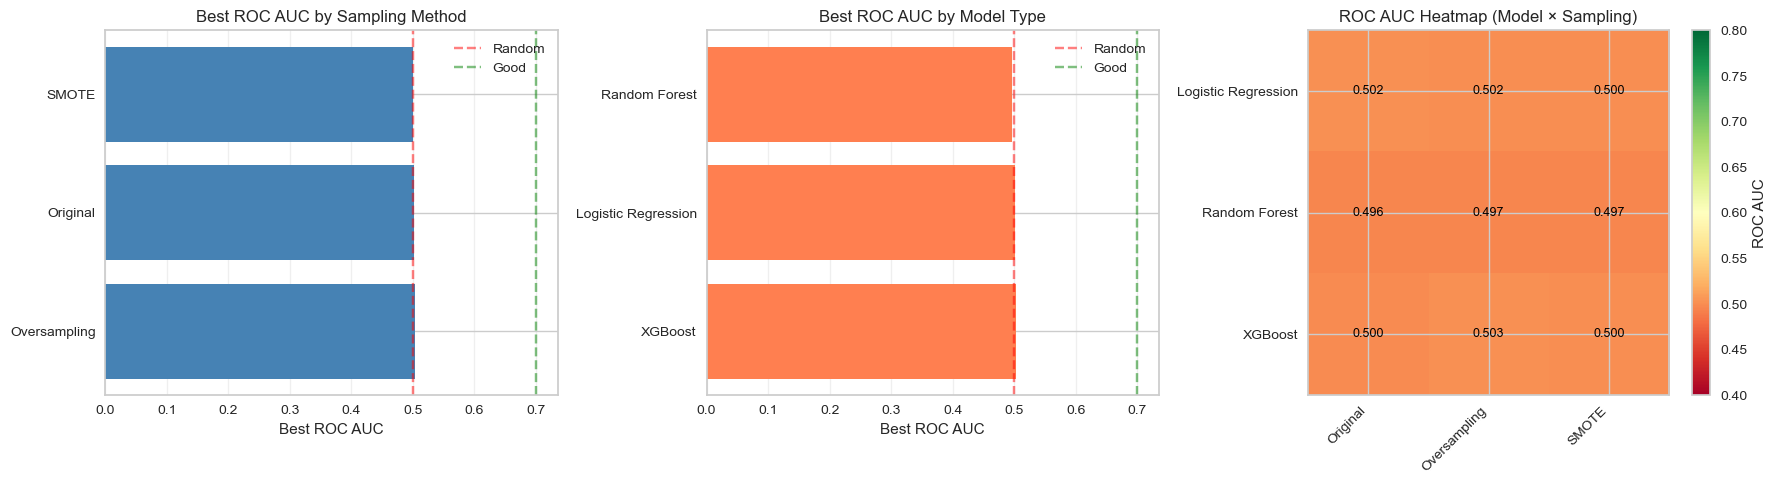


KEY INSIGHTS

Best Configuration Details:
   Sampling: Oversampling
   Model: XGBoost
   ROC AUC: 0.5027
   PR AUC: 0.2211
   Class Separation: 0.0002
   Training Size: 1,110,394 samples


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#ROC AUC by Sampling method
sampling_roc = results_df.groupby('Sampling')['ROC AUC'].max().sort_values(ascending=False)
axes[0].barh(range(len(sampling_roc)), sampling_roc.values, color='steelblue')
axes[0].set_yticks(range(len(sampling_roc)))
axes[0].set_yticklabels(sampling_roc.index)
axes[0].set_xlabel('Best ROC AUC')
axes[0].set_title('Best ROC AUC by Sampling Method')
axes[0].axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0].axvline(0.7, color='green', linestyle='--', alpha=0.5, label='Good')
axes[0].legend()   
axes[0].grid(alpha=0.3, axis='x')

#ROC AUC by Model Type
model_roc = results_df.groupby('Model')['ROC AUC'].max().sort_values(ascending=False)
axes[1].barh(range(len(model_roc)), model_roc.values, color='coral')
axes[1].set_yticks(range(len(model_roc)))
axes[1].set_yticklabels(model_roc.index)
axes[1].set_xlabel('Best ROC AUC')
axes[1].set_title('Best ROC AUC by Model Type')
axes[1].axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[1].axvline(0.7, color='green', linestyle='--', alpha=0.5, label='Good')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='x')

#heatmap of all combinations
pivot_roc = results_df.pivot(index='Model', columns='Sampling', values='ROC AUC')
im = axes[2].imshow(pivot_roc.values, cmap='RdYlGn', aspect='auto', vmin=0.4, vmax=0.8)
axes[2].set_xticks(range(len(pivot_roc.columns)))
axes[2].set_xticklabels(pivot_roc.columns, rotation=45, ha='right')
axes[2].set_yticks(range(len(pivot_roc.index)))
axes[2].set_yticklabels(pivot_roc.index)
axes[2].set_title('ROC AUC Heatmap (Model × Sampling)')   

for i in range(len(pivot_roc.index)):
    for j in range(len(pivot_roc.columns)):
        text = axes[2].text(j, i, f'{pivot_roc.values[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=9)




plt.colorbar(im, ax=axes[2], label='ROC AUC')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

#if sampling changed class separation
best_result = results_df.iloc[0]
print(f"\nBest Configuration Details:")
print(f"   Sampling: {best_result['Sampling']}")
print(f"   Model: {best_result['Model']}")
print(f"   ROC AUC: {best_result['ROC AUC']:.4f}")
print(f"   PR AUC: {best_result['PR AUC']:.4f}")
print(f"   Class Separation: {best_result['Class Sep']:.4f}")
print(f"   Training Size: {best_result['Train Size']:,} samples")


### Diagnostic: Score Distribution Analysis


In [20]:
def diagnostic_score_analysis(model, X_val, y_val, model_name="Model", positive_class_fn=None):
    if positive_class_fn is not None:
        y_score_val = positive_class_fn(model, X_val)
    else:
        if hasattr(model, "predict_proba"):
            y_score_val = model.predict_proba(X_val)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score_val = model.decision_function(X_val)


    print(f"\nScore Statistics (Validation Set):")
    print(f"   Mean:   {np.mean(y_score_val):.4f}")
    print(f"   Median: {np.median(y_score_val):.4f}")
    print(f"   Std:    {np.std(y_score_val):.4f}")
    print(f"   Min:    {np.min(y_score_val):.4f}")
    print(f"   Max:    {np.max(y_score_val):.4f}")
    print(f"   Range:  {np.max(y_score_val) - np.min(y_score_val):.4f}")

    # base survival rate
    baseline_survival = y_val.mean()
    print(f"\n   Baseline survival rate: {baseline_survival:.4f} ({baseline_survival*100:.1f}%)")

    # dsitr by class
    scores_survived= y_score_val[y_val == 1]
    scores_died= y_score_val[y_val == 0]
    diff = np.mean(scores_survived) - np.mean(scores_died)  

    print(f"\nScores by Actual Outcome:")
    print(f"   Survived (y=1): mean={np.mean(scores_survived):.4f}, std={np.std(scores_survived):.4f}")   
    print(f"   Died (y=0):     mean={np.mean(scores_died):.4f}, std={np.std(scores_died):.4f}")   
    print(f"   Difference:     {diff:.4f}")    

    
    auc = roc_auc_score(y_val, y_score_val)
    print(f"\nROC AUC: {auc:.4f}")
    if abs(diff) < 0.05:
        print("\nCRITICAL WARNING: <0.05 mean diff — Model cannot distinguish well between survived and died patients.")



    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(scores_died, bins=50, alpha=0.6, label='Died (y=0)', color='red', density=True)
    axes[0].hist(scores_survived, bins=50, alpha=0.6, label='Survived (y=1)', color='green', density=True)
    axes[0].axvline(baseline_survival, color='black', linestyle='--', label=f'Baseline ({baseline_survival:.2f})')
    axes[0].set_xlabel('Predicted Survival Probability')
    axes[0].set_ylabel('Density')
    axes[0].set_title(f'{model_name}: Score Distribution by Actual Outcome')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    data_to_plot = [scores_died, scores_survived]
    axes[1].boxplot(data_to_plot, labels=['Died (y=0)', 'Survived (y=1)'])
    axes[1].axhline(baseline_survival, color='black', linestyle='--', alpha=0.5, label='Baseline')
    axes[1].set_ylabel('Predicted Survival Probability')
    axes[1].set_title(f'{model_name}: Boxplot Distribution')
    axes[1].grid(alpha=0.3, axis='y')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return y_score_val 

### Visualize best model performance


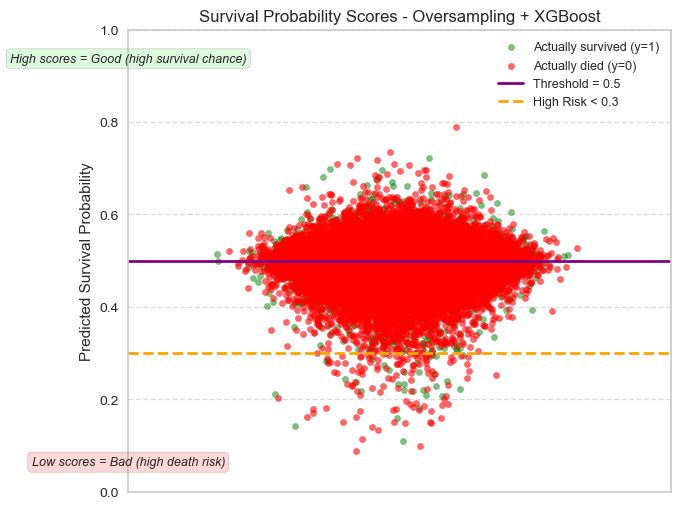

Oversampling + XGBoost
PR AUC: 0.221
ROC AUC: 0.503
Prevalence p = 0.220  |  PR AUC lift = 1.00× over baseline


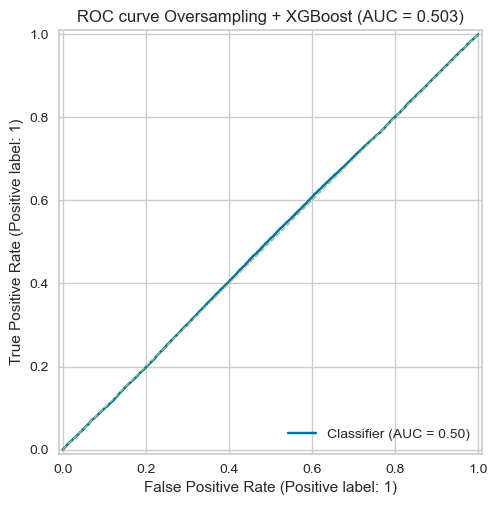

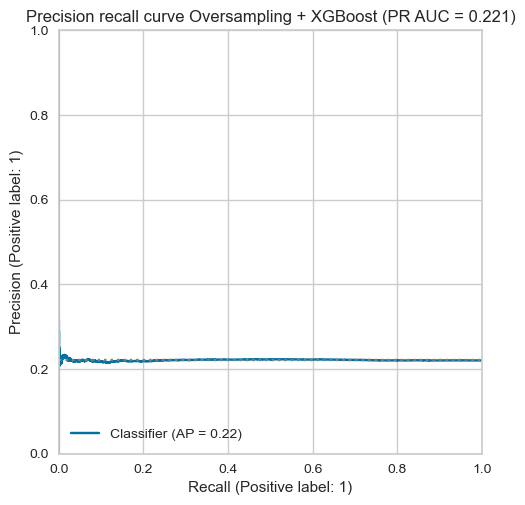

In [21]:
scores = positive_scores(best_model, X_val)
actuals = y_val

scores_survived = scores[actuals == 1]  # Patients who actually survived (y=1)
scores_died = scores[actuals== 0]      # Patients who actually died (y=0)

jitter_strength = 0.03
jitter_survived = np.random.normal(0, jitter_strength, len(scores_survived))  
jitter_died = np.random.normal(0, jitter_strength, len(scores_died))     

fig, ax = plt.subplots(figsize=(7, 6))
scatter_survived = ax.scatter(jitter_survived, scores_survived, color='green', alpha=0.5, label='Actually survived (y=1)', s=20)
scatter_died = ax.scatter(jitter_died, scores_died, color='red', alpha=0.6, label='Actually died (y=0)', s=20)   
line_50= ax.axhline(y=0.5, color='purple', linestyle='-', linewidth=2, label='Threshold = 0.5')
line_30= ax.axhline(y=0.3, color='orange', linestyle='--', linewidth=2, label='High Risk < 0.3')   



ax.set_title(f'Survival Probability Scores - {best_model_name}')  
ax.set_ylabel('Predicted Survival Probability')
ax.set_ylim(0, 1)  
ax.set_xticks([])  
ax.set_xlim(-0.2, 0.2)  
ax.legend(handles=[scatter_survived, scatter_died, line_50, line_30], fontsize=9, loc='best')
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.text(0, 0.95, 'High scores = Good (high survival chance)', ha='center', va='top', 
        transform=ax.transAxes, fontsize=9, style='italic', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax.text(0, 0.05, 'Low scores = Bad (high death risk)', ha='center', va='bottom',
        transform=ax.transAxes, fontsize=9, style='italic', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
plt.show()

#detailed report
metrics = auc_report(y_val, scores, name=best_model_name, plot=True)


# 6. Recalibrating the Scores

**IMPORTANT: Interpreting Survival Probabilities for Clinical Use**

Our model predicts **survival probability**:
- **High score (e.g., 0.8)** = 80% chance of survival → **Low risk** patient
- **Low score (e.g., 0.2)** = 20% chance of survival → **High risk** patient

For clinical interventions, we want to identify **high-risk patients** (those likely to die), which corresponds to **LOW survival probabilities**.

**Two approaches for threshold-based decisions:**
1. **Threshold on LOW scores**: Alert if `survival_prob < 0.3` (i.e., < 30% survival chance)
2. **Convert to death risk**: `death_risk = 1 - survival_prob`, then alert if `death_risk > 0.7`

The rest of this notebook uses standard RAI framework conventions (where high scores indicate the "positive class" = survived). Keep this interpretation in mind when setting thresholds!

---

**Why Calibrate?**

**1. Reliable probabilities**  
- Turns raw scores into real probabilities  
- Ensures predictions match observed outcome frequencies  

**2. Better clinical decisions**  
- Essential when risk values guide medical choices  
- Supports thresholds with clear clinical meaning  

**3. Trust and adoption**  
- Builds trust in AI decisions  
- Enables safer patient outcomes

In [23]:
# Calibrate probabilities using CV on training data
# Using the best model selected above
calibrated_clf = CalibratedClassifierCV(
    estimator=best_model,
    method="sigmoid",
    cv=5
)
print(f"Calibrating {best_model_name}...")
calibrated_clf.fit(X_train, y_train)
print("✓ Calibration complete")

Calibrating Oversampling + XGBoost...
✓ Calibration complete


,Survival_band,Patients,Avg_pred_before,Actual_survival_rate,Avg_pred_after
0,Q1,4453,0.247,0.225,0.22
1,Q2,4482,0.233,0.217,0.22
2,Q3,4419,0.229,0.230,0.22
3,Q4,4463,0.225,0.219,0.22
4,Q5,4455,0.222,0.220,0.22
5,Q6,4474,0.219,0.214,0.22
6,Q7,4470,0.216,0.229,0.22
7,Q8,4428,0.212,0.220,0.22
8,Q9,4427,0.207,0.208,0.22
9,Q10,4429,0.193,0.221,0.22


Check sizes
len(X_train) = 712000 len(X_val) = 133500 len(X_test) = 44500
Rows in table sum to 44500


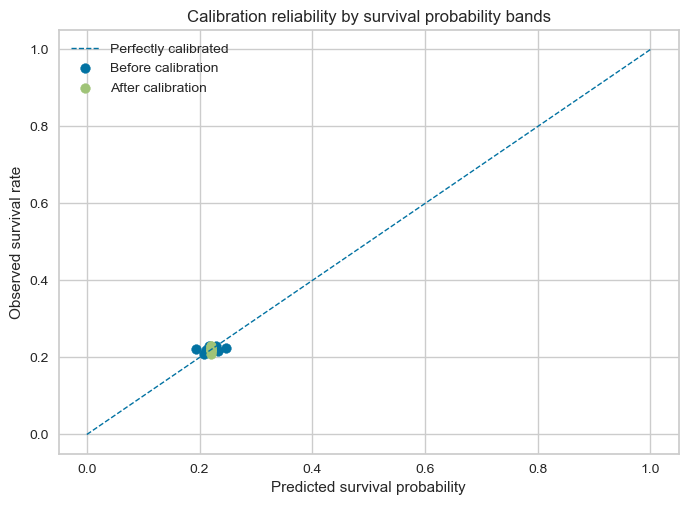

In [24]:
# Quantile bands on test only
best_model_uncal = clone(best_model).fit(X_train, y_train)
p_before = best_model_uncal.predict_proba(X_test)[:, 1]
p_after = calibrated_clf.predict_proba(X_test)[:, 1]

# y_test: 1=survived, 0=died
#predicts P(survived=1) = survival probability
df_cal = pd.DataFrame({"Actual_Survived": y_test.values, "Pred_before": p_before,
                      "Pred_after": p_after}, index=X_test.index)

# 10 quantile bands with similar counts
df_cal["Survival_band"] = pd.qcut(df_cal["Pred_after"], q=10, labels=[
                              f"Q{i}" for i in range(1, 11)], duplicates="drop")

summary = (
    df_cal.groupby("Survival_band", observed=True)
    .agg(Patients=("Actual_Survived", "size"),
         Avg_pred_before=("Pred_before", "mean"),
         Actual_survival_rate=("Actual_Survived", "mean"),
         Avg_pred_after=("Pred_after", "mean"))
    .reset_index()
    .round(3)
)
display(summary)

print("Check sizes")
print("len(X_train) =", len(X_train), "len(X_val) =",
      len(X_val), "len(X_test) =", len(X_test))
print("Rows in table sum to", int(summary["Patients"].sum()))

# Reliability plot using the same fixed risk bands summary
plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--",
         linewidth=1, label="Perfectly calibrated")
plt.scatter(summary["Avg_pred_before"],
            summary["Actual_survival_rate"], label="Before calibration")
plt.scatter(summary["Avg_pred_after"],
            summary["Actual_survival_rate"],  label="After calibration")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival rate")
plt.title("Calibration reliability by survival probability bands")
plt.legend()     
plt.show()   

### Compare base_clf vs calibrated_clf on validation

In [25]:
# Focus on discrimination equality and calibration improvements

# Scores
y_score_val_uncal = positive_scores(best_model, X_val)
y_score_val_cal = positive_scores(calibrated_clf, X_val)

# Discrimination
roc_uncal = roc_auc_score(y_val, y_score_val_uncal)
pr_uncal = average_precision_score(y_val, y_score_val_uncal)
roc_cal = roc_auc_score(y_val, y_score_val_cal)
pr_cal = average_precision_score(y_val, y_score_val_cal)

# Calibration
ll_uncal = log_loss(y_val, np.clip(y_score_val_uncal, 1e-6, 1 - 1e-6))
ll_cal = log_loss(y_val, np.clip(y_score_val_cal,  1e-6, 1 - 1e-6))
brier_uncal = brier_score_loss(y_val, y_score_val_uncal)
brier_cal = brier_score_loss(y_val, y_score_val_cal)

# Assemble into dataframe
metrics_df = pd.DataFrame([
    {"Metric": "ROC AUC", "Uncalibrated": roc_uncal, "Calibrated": roc_cal, "Explanation": "Ability to distinguish between classes (higher is better)"},
    {"Metric": "PR AUC", "Uncalibrated": pr_uncal, "Calibrated": pr_cal, "Explanation": "Precision-recall curve area; useful for imbalanced data"},
    {"Metric": "Log loss", "Uncalibrated": ll_uncal, "Calibrated": ll_cal, "Explanation": "Penalty for incorrect and overconfident predictions (lower is better)"},
    {"Metric": "Brier score", "Uncalibrated": brier_uncal, "Calibrated": brier_cal, "Explanation": "Mean squared error of predicted probabilities (lower is better)"},
])

display(metrics_df.style.format({"Uncalibrated": "{:.3f}", "Calibrated": "{:.3f}"}))

,Metric,Uncalibrated,Calibrated,Explanation
0,ROC AUC,0.503,0.499,Ability to distinguish between classes (higher is better)
1,PR AUC,0.221,0.220,Precision-recall curve area; useful for imbalanced data
2,Log loss,0.690,0.527,Penalty for incorrect and overconfident predictions (lower is better)
3,Brier score,0.249,0.172,Mean squared error of predicted probabilities (lower is better)


# 7. Deciding where to cut off i.e. what probability is “high risk enough” to trigger an intervention?

,precision,recall,alerts_per_1000,true_pos_per_1000,FP,FN
threshold,,,,,,
0.1,0.221,1.0,1000.0,220.614,52024,0
0.2,0.221,1.0,1000.0,220.614,52024,0
0.3,0.000,0.0,0.0,0.000,0,14726
0.4,0.000,0.0,0.0,0.000,0,14726
0.5,0.000,0.0,0.0,0.000,0,14726


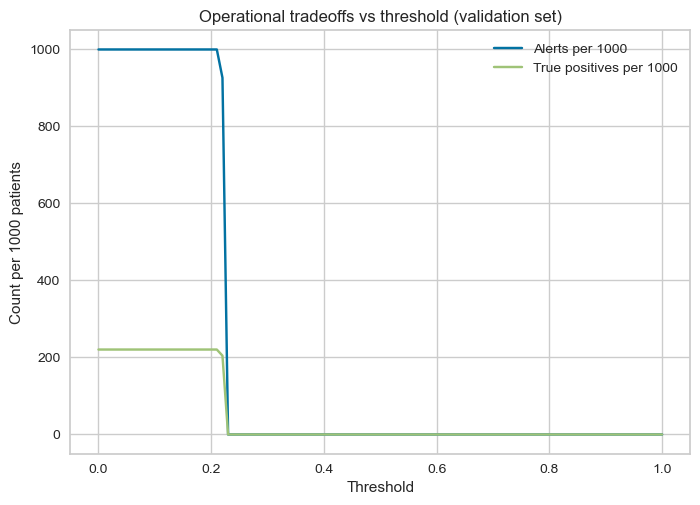

In [ ]:
# Get calibrated probabilities
y_score_val = positive_scores(calibrated_clf, X_val)

# Define a grid of thresholds
thresholds = np.linspace(0, 1, 101)
rows = []
for thr in thresholds:
    y_pred = (y_score_val >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    alerts_per_1000 = 1000 * np.mean(y_pred)
    true_pos_per_1000 = 1000 * tp / len(y_val)
    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "alerts_per_1000": alerts_per_1000,
        "true_pos_per_1000": true_pos_per_1000,
        "FP": fp,
        "FN": fn
    })

df_thr = pd.DataFrame(rows)

# Display a few candidate thresholds for discussion
display(
    df_thr.query("threshold in [0.1, 0.2, 0.3, 0.4, 0.5]")
         .round(3)
         .set_index("threshold")
)

# Plot workload vs threshold
plt.figure()
plt.plot(df_thr["threshold"], df_thr["alerts_per_1000"], label="Alerts per 1000")
plt.plot(df_thr["threshold"], df_thr["true_pos_per_1000"], label="True positives per 1000")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000 patients")
plt.title("Operational tradeoffs vs threshold (validation set)")
plt.legend()
plt.show()

## 7.1. Choosing an operating threshold

Models produce probabilities, but clinicians are the ones taking decisions, and carring the accountability of their actions.

- Setting a threshold balances in this case, among others, between missed addiction cases and unnecessary undertreatment of pain
- Clear rules make these tradeoffs explicit, explainable, and auditable!

We will run three threshold tuning analyses:
1. **Workload constrained threshold**  
  Capture the most true cases without exceeding a fixed alert capacity for the clinic
2. **Recall floor then maximize precision**  
  Guarantee a minimum case capture for safety, then pick the threshold with the fewest false alarms
3. **Cost based threshold (Bayes rule)**  
  Minimize expected harm using estimated costs for false negatives and false positives

Readouts to watch
- Threshold, precision, recall, alerts per 1000 patients, true positives per 1000, false positives, false negatives
- Connect the chosen rule to clinical policy and resource capacity

### 7.1.1. Workload constrained threshold for calibrated_clf on validation

- Alerts budget: maximum alerts per 1000 patients the clinic can review without overloading resources
- Objective: within the alerts budget, choose the threshold that yields the most true positives per 1000 so more patients at real risk are correctly flagged

In [ ]:
summary.head()

,Survival_band,Patients,Avg_pred_before,Actual_survival_rate,Avg_pred_after
0,Q1,2225,0.247,0.222,0.220
1,Q2,2225,0.232,0.225,0.220
2,Q3,2225,0.228,0.216,0.220
3,Q4,2225,0.225,0.222,0.220
4,Q5,2225,0.223,0.217,0.221


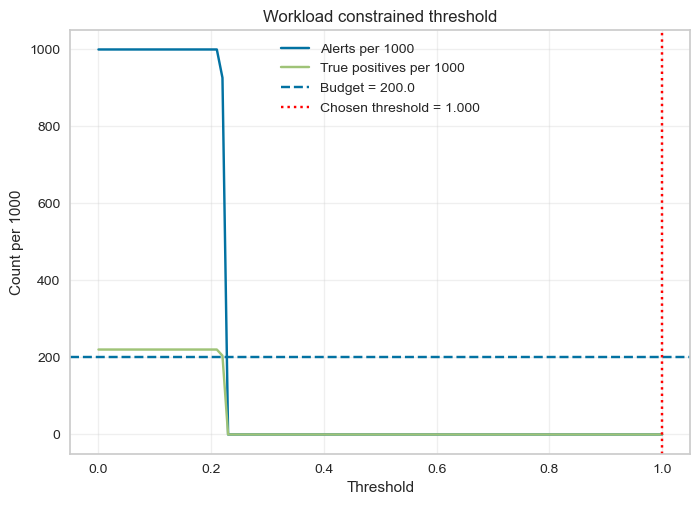


📊 Workload-Constrained Threshold: 1.000


,threshold,precision,recall,TP,FP,TN,FN,alerts_per_1000,true_pos_per_1000
0,1.0,0.0,0.0,0,0,52024,14726,0.0,0.0


In [ ]:
ALERTS_BUDGET = 200.0  # alerts per 1000 patients
# For lung cancer: patients flagged as high death risk for aggressive treatment/monitoring
# Higher budget than opioid use case since ~20% of patients die anyway

y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
tbl = res["table"]
THR_work = res["threshold"]

# Plot
plt.figure()
plt.plot(tbl["threshold"], tbl["alerts_per_1000"], label="Alerts per 1000")
plt.plot(tbl["threshold"], tbl["true_pos_per_1000"], label="True positives per 1000")
plt.axhline(ALERTS_BUDGET, linestyle="--", label=f"Budget = {ALERTS_BUDGET}")
plt.axvline(THR_work, linestyle=":", color='red', label=f"Chosen threshold = {THR_work:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000")
plt.title("Workload constrained threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Display metrics at chosen threshold
summary_work = summary_at_threshold(y_val, y_score_val, THR_work)
print(f"\n📊 Workload-Constrained Threshold: {THR_work:.3f}")
display(summary_work.round(3))


Let's now see the risk groups by decile (bands), and visualizes the overall risk score distribution, with optional threshold overlay and decile boundaries

,n,positives,min_score,max_score,prevalence,cum_capture,alerts_per_1000,true_pos_per_1000
band,,,,,,,,
1,6675,1404,0.221,0.226,0.210,0.095,100.0,21.034
2,6675,1456,0.221,0.221,0.218,0.194,100.0,21.813
3,6675,1496,0.221,0.221,0.224,0.296,100.0,22.412
4,6675,1425,0.221,0.221,0.213,0.393,100.0,21.348
5,6675,1445,0.221,0.221,0.216,0.491,100.0,21.648
6,6675,1498,0.220,0.221,0.224,0.592,100.0,22.442
7,6675,1508,0.220,0.220,0.226,0.695,100.0,22.592
8,6675,1528,0.220,0.220,0.229,0.799,100.0,22.891
9,6675,1508,0.220,0.220,0.226,0.901,100.0,22.592


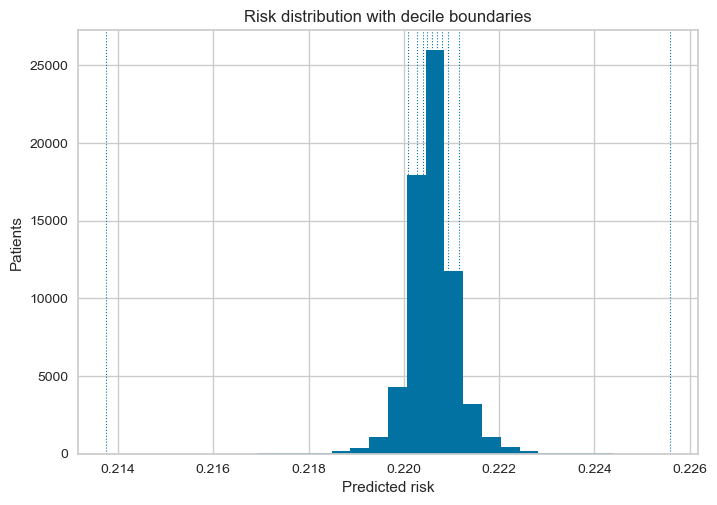

In [ ]:
N_BINS = 10  # deciles by default
y_score_val = positive_scores(calibrated_clf, X_val)

# Build bands by quantiles, highest risk = band 1
bands = pd.qcut(y_score_val, q=N_BINS, labels=False, duplicates="drop")
# qcut labels lowest=0..highest=K-1, invert so 1 is highest-risk band
bands = (bands.max() - bands) + 1

df = pd.DataFrame({
    "y_true": y_val.astype(int),
    "score": y_score_val,
    "band": bands.astype(int),
})

summ = (df.groupby("band", as_index=True)
          .agg(n=("y_true","size"),
               positives=("y_true","sum"),
               min_score=("score","min"),
               max_score=("score","max"))
          .sort_index())

summ["prevalence"] = summ["positives"] / summ["n"]
summ["cum_capture"] = summ["positives"].cumsum() / df["y_true"].sum()
summ["alerts_per_1000"] = 1000.0 * summ["n"] / len(df)
summ["true_pos_per_1000"] = 1000.0 * summ["positives"] / len(df)

display(summ.round(3))

# Optional threshold overlay if you already chose one, else set THR=None
THR = None  # e.g., THR = 0.23

# Histogram of risk scores with decile edges
plt.figure()
plt.hist(df["score"], bins=30)
if THR is not None:
    plt.axvline(THR, linestyle="--")
# draw decile boundaries
edges = np.quantile(df["score"], np.linspace(0,1,N_BINS+1))
for x in edges:
    plt.axvline(x, linestyle=":", linewidth=0.8)
plt.xlabel("Predicted risk")
plt.ylabel("Patients")
plt.title("Risk distribution with decile boundaries")
plt.show()


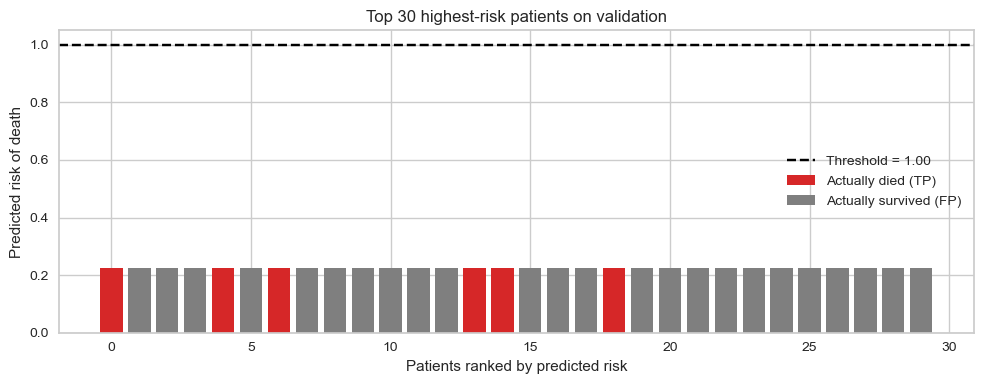

In [ ]:
THR = THR_work # <- use the threshold from workload constraint analysis
y_score_val = positive_scores(calibrated_clf, X_val)
ids = np.arange(len(y_val))

# Sort patients by predicted risk
order = np.argsort(-y_score_val)
top_idx = order[:30]   # top 30 for visualization
top_scores = y_score_val[top_idx]
top_true = np.asarray(y_val)[top_idx].astype(int)

# Split indices for TP vs FP
tp_idx = np.where(top_true == 1)[0]
fp_idx = np.where(top_true == 0)[0]

plt.figure(figsize=(10, 4))
plt.bar(tp_idx, top_scores[tp_idx], color="tab:red", label="Actually died (TP)")
plt.bar(fp_idx, top_scores[fp_idx], color="tab:gray", label="Actually survived (FP)")
plt.axhline(THR, linestyle="--", color="black", label=f"Threshold = {THR:.2f}")

plt.xlabel("Patients ranked by predicted risk")
plt.ylabel("Predicted risk of death")
plt.title("Top 30 highest-risk patients on validation")
plt.legend()
plt.tight_layout()
plt.show()

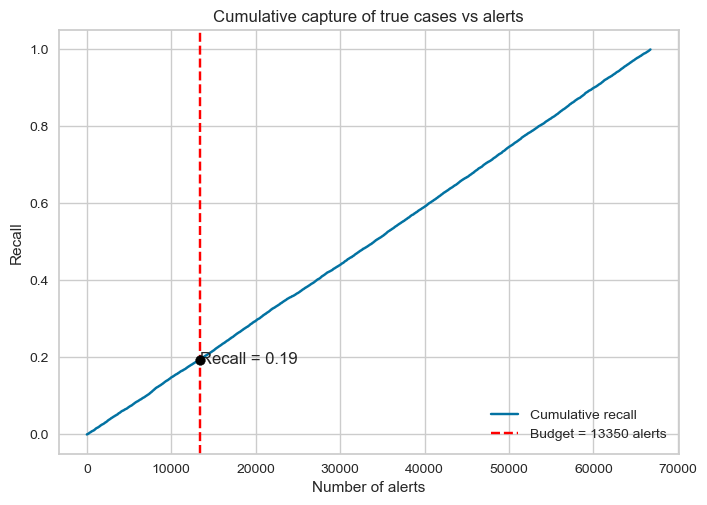

In [ ]:
y_score_val = positive_scores(calibrated_clf, X_val)
order = np.argsort(-y_score_val)
y_sorted = np.asarray(y_val)[order].astype(int)

# Cumulative recall
cum_tp = np.cumsum(y_sorted)
total_pos = cum_tp[-1] if cum_tp.size else 0
alerts = np.arange(1, len(y_sorted) + 1)
recall_curve = cum_tp / total_pos if total_pos > 0 else np.zeros_like(cum_tp)

# Budget for alerts
n_budget = int(np.ceil(ALERTS_BUDGET * len(y_val) / 1000.0))

# Recall at budget
recall_at_budget = recall_curve[n_budget - 1] if n_budget > 0 and n_budget <= len(y_val) else 0.0

# Plot
plt.figure()
plt.plot(alerts, recall_curve, label="Cumulative recall")
plt.axvline(n_budget, linestyle="--", color="red", label=f"Budget = {n_budget} alerts")

# Annotate recall at budget
plt.scatter(n_budget, recall_at_budget, color="black", zorder=5)
plt.text(n_budget + 2, recall_at_budget, f"Recall = {recall_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Recall")
plt.title("Cumulative capture of true cases vs alerts")
plt.legend()
plt.show()

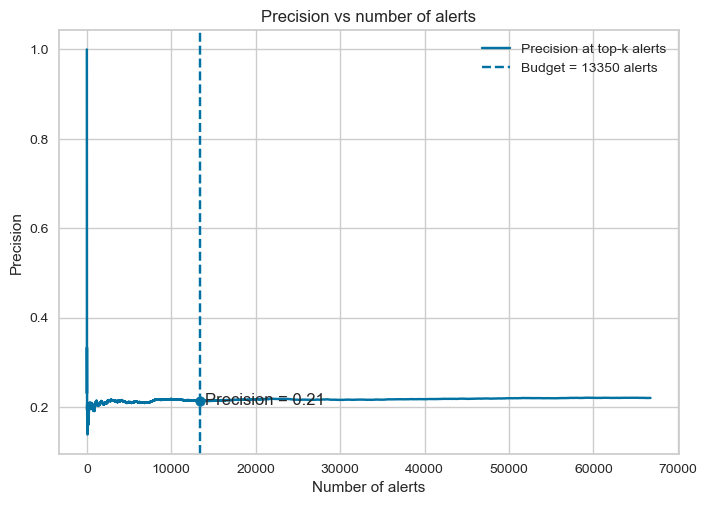

In [ ]:
# Cumulative precision at top-k alerts
alerts = np.arange(1, len(y_sorted) + 1)
cum_tp = np.cumsum(y_sorted)
precision_curve = cum_tp / alerts

# Alerts budget scaled to validation size
prec_at_budget = precision_curve[n_budget - 1] if 0 < n_budget <= len(y_sorted) else 0.0

# Plot
plt.figure()
plt.plot(alerts, precision_curve, label="Precision at top-k alerts")
plt.axvline(n_budget, linestyle="--", label=f"Budget = {n_budget} alerts")
plt.scatter(n_budget, prec_at_budget, zorder=5)
plt.text(n_budget + max(2, len(y_sorted)//100), prec_at_budget, f"Precision = {prec_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Precision")
plt.title("Precision vs number of alerts")
plt.legend()
plt.show()


### 7.1.2. Recall floor then maximize precision for calibrated_clf on validation

- Recall floor: minimum acceptable recall set by safety policy to limit missed addiction cases
- Precision objective: among thresholds meeting the recall floor, pick the one with highest precision to reduce unnecessary undertreatment and clinician workload

Deciding which recall floor to sue:
1. The chosen floor is a value judgment balancing patient safety vs resource burden
2. In medicine, it's often the case that missing a true case (false negative) is often much worse than raising extra alarms (false positives)
3. A recall floor enforces a safety guarantee: the model must capture at least e.g. 60% of patients who will become addicted

Among thresholds that satisfy recall ≥ 0.6, you then pick the one with the best precision, to minimize unnecessary undertreatment and workload

threshold,0.22
metric,
precision,0.221
recall,0.928
TP,13660.000
FP,48187.000
TN,3837.000
FN,1066.000
alerts_per_1000,926.547
true_pos_per_1000,204.644


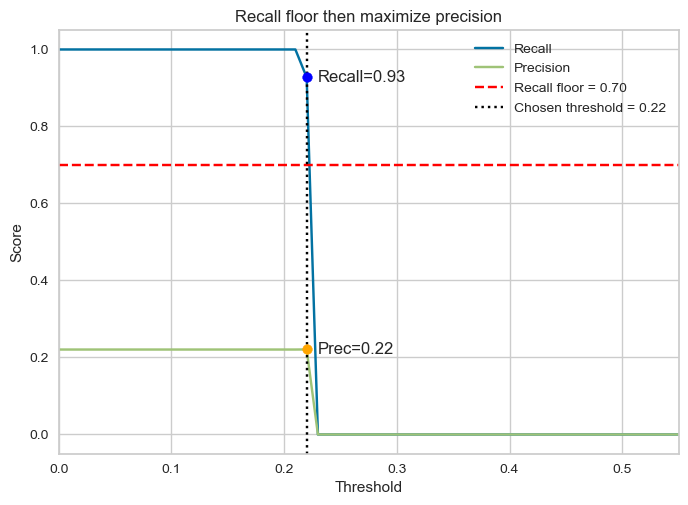

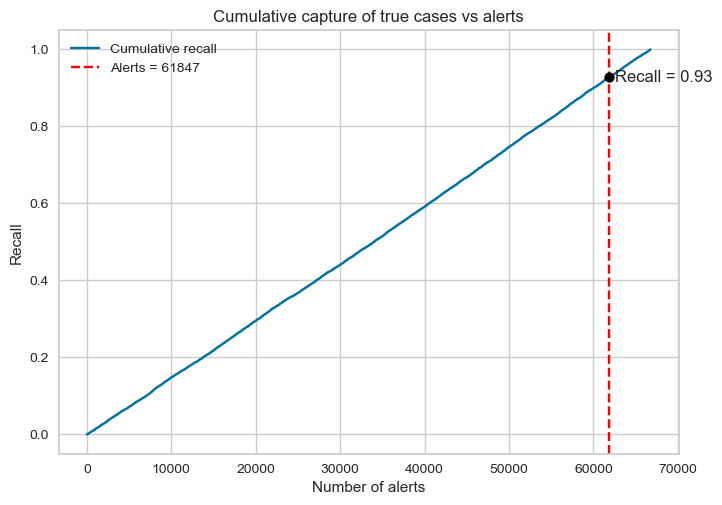

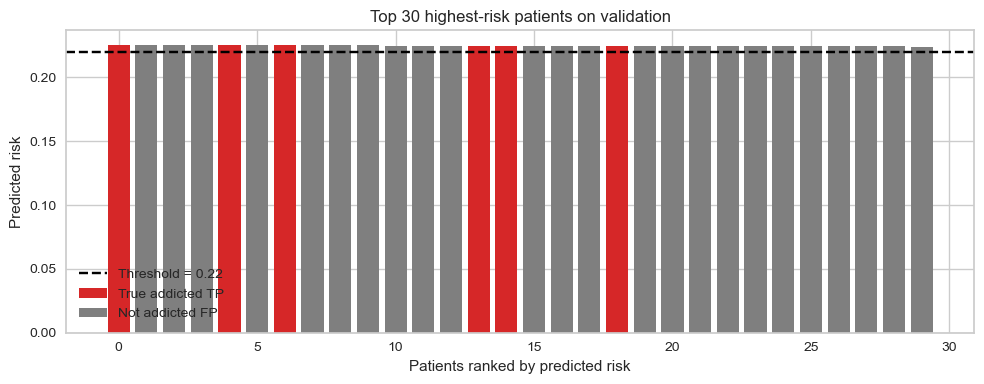

In [ ]:
# Step 1: choose threshold by recall floor
RECALL_FLOOR = 0.70 # <- judgment call
# For lung cancer: aiming to catch 70% of deaths to provide life-saving interventions
# Missing 30% of deaths is still concerning, but balances with treatment side effects
y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
THR = float(res["threshold"])

summary_df = summary_at_threshold(y_val, y_score_val, THR)
pivot_df = summary_df.set_index("threshold").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))

# Precision and recall vs threshold with annotations
plot_recall_floor_curves(y_val, y_score_val, recall_floor=RECALL_FLOOR, chosen_threshold=THR)

# Cumulative recall vs alerts with vertical line at alerts implied by THR
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)

# Patient-level prioritization view at THR
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)

### 7.1.3. Cost based threshold for calibrated_clf on validation

**IMPORTANT: Cost Interpretation for Survival Prediction**

Since we're predicting **survival probability** (y=1 = survived), the confusion matrix works differently:

**Confusion Matrix for Survival Prediction:**
- **TP (True Positive)**: Predicted survived (score ≥ threshold), Actually survived → ✓ Correct
- **FP (False Positive)**: Predicted survived (score ≥ threshold), Actually died → ✗ **MOST DANGEROUS!**
  - We thought patient would survive, so didn't treat aggressively → patient dies
- **TN (True Negative)**: Predicted died (score < threshold), Actually died → ✓ Correct, expected outcome
- **FN (False Negative)**: Predicted died (score < threshold), Actually survived → ✗ Over-treated
  - We thought patient would die, so treated aggressively → patient survived anyway (with side effects)

**Cost Analysis:**
- **C_FP (False Positive cost)**: HIGHEST COST - Patient dies when we predicted survival
  - Didn't provide aggressive treatment → preventable death
- **C_FN (False Negative cost)**: Lower cost - Patient survives despite our pessimistic prediction
  - Over-treated with side effects, but patient lived

**For survival prediction, FP > FN in cost!** (opposite of death risk prediction)

rule,Bayes formula,Empirical min cost
metric,,
threshold,0.91,0.23
precision,0.00,0.00
recall,0.00,0.00
TP,0.00,0.00
FP,0.00,0.00
TN,52024.00,52024.00
FN,14726.00,14726.00
alerts_per_1000,0.00,0.00
true_pos_per_1000,0.00,0.00


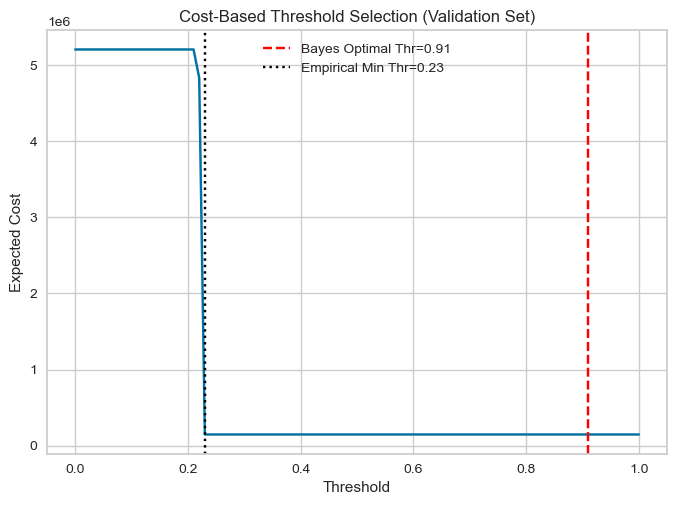

In [ ]:
# Set domain costs for lung cancer SURVIVAL prediction
# Remember: We're predicting P(survived=1), so high scores = high survival probability
C_FP = 100.0  # Cost of False Positive: Predicted survival but patient DIED
              # HIGHEST COST: Patient dies because we didn't treat aggressively enough
              # We were optimistic about survival → inadequate treatment → preventable death
              # Includes: loss of life, emotional cost, malpractice risk
              
C_FN = 10.0   # Cost of False Negative: Predicted death but patient SURVIVED  
              # Lower cost: Over-treated patient unnecessarily
              # We were pessimistic → aggressive treatment with side effects → but patient lived
              # Includes: treatment toxicity, reduced quality of life, healthcare costs
              
# Ratio: FP:FN = 10:1 (FP is 10x more costly)

# Get scores from the calibrated model on the validation set
y_score_val = positive_scores(calibrated_clf, X_val)

# Find the optimal thresholds based on cost
res = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
tbl = res["table"].copy()
tbl["expected_cost"] = C_FP * tbl["FP"] + C_FN * tbl["FN"]

# Display a summary table comparing the two threshold options
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])

pivot_df = (
    summary_df.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Plot expected cost vs. threshold
plt.figure()
plt.plot(tbl["threshold"], tbl["expected_cost"])
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost-Based Threshold Selection (Validation Set)")

# Annotate the two optimal thresholds found
t_formula = res["threshold_formula"]
t_emp = res["threshold_empirical"]
plt.axvline(t_formula, linestyle="--", color="red", label=f"Bayes Optimal Thr={t_formula:.2f}")
plt.axvline(t_emp, linestyle=":", color="black", label=f"Empirical Min Thr={t_emp:.2f}")
plt.legend()
plt.show()


Visualizing performance at the empirical cost-based threshold of 0.230:


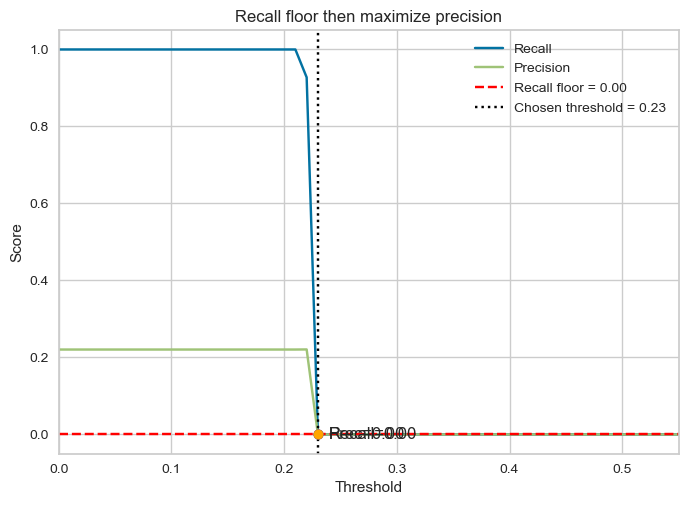

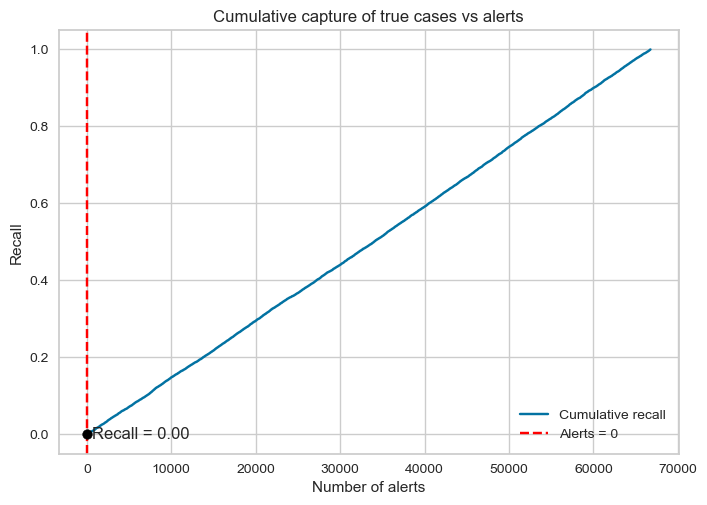

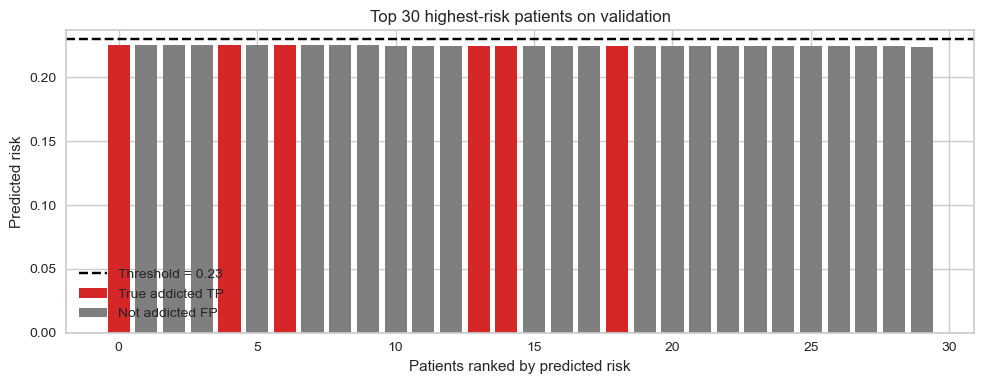

In [ ]:
# Get the empirically optimal threshold from the previous analysis
THR = res["threshold_empirical"]

# For visualization, we need a "recall_floor" to draw the horizontal line.
# We'll use the actual recall achieved at our chosen cost-based threshold.
y_pred_val = (y_score_val >= THR).astype(int)
recall_at_thr = recall_score(y_val, y_pred_val)

print(f"Visualizing performance at the empirical cost-based threshold of {THR:.3f}:")
plot_recall_floor_curves(y_val, y_score_val, recall_floor=recall_at_thr, chosen_threshold=THR)
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)


# 8. Final Threshold Selection and Test Set Evaluation

This is a crucial step that often involves discussion with clinical stakeholders to align the model's operating point with clinical goals, patient safety requirements, and resource availability

| Thresholding Method | Objective | Pros (Best for...) | Cons (Potential Risks) |
| :--- | :--- | :--- | :--- |
| **1. Workload Constrained** | Maximize TP (addiction risk) under a fixed (alert) budget | Good for limited resources, ensuring Ops stability | A low budget will miss many high-risk patients |
| **2. Recall Floor** | Maximize precision (TP vs. FP) while holding a minimum recall rate (breath) | Acts as a safety net, ensuring a minimum capture rate | Increases false alarms e.g. workloads from alternative treatments, untreated pain |
| **3. Cost-Based** | Minimize total expected cost by assigning costs to errors | Provides a formal f/ work to balance different clinical errors | Highly dependent on accurate cost estimates (can be subjective) |

1. Compute the candidate threshold (THR) for each policy on the validation set
2. Compare them on consistent operational metrics and expected cost
3. Lock the final threshold using the same (THR) variable, to get an unbiased estimate

In [ ]:
# Thresholds are derived on validation, comparison is on test

# Scores
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

# Derive thresholds on validation only, for the three methods
res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# Compare policies on the unseen test set using the frozen (validation) thresholds
rows = []
for approach, thr in [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
]:
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
    })
    rows.append(s)

test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Also report threshold-independent curve metrics on test for context
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp
metric,,,
threshold,1.0,0.220,0.23
precision,0.0,0.220,0.00
recall,0.0,0.923,0.00
alerts_per_1000,0.0,925.169,0.00
true_pos_per_1000,0.0,203.551,0.00
TP,0.0,4529.000,0.00
FP,0.0,16056.000,0.00
FN,4909.0,380.000,4909.00
expected_cost,49090.0,1609400.000,49090.00


Test ROC AUC=0.498  |  Test PR AUC=0.219


In [ ]:
test_compare = test_compare.sort_values('approach').reset_index(drop=True)

# Extract stats for each approach from the DataFrame
workload_stats = test_compare.iloc[0]
recall_stats = test_compare.iloc[1]
cost_stats = test_compare.iloc[2]

# Calculate total positive cases in the test set
total_pos_test = workload_stats['TP'] + workload_stats['FN']

# Dynamic markdown with increased font size using HTML <div>
markdown_text = f"""
* **Workload Constraint (THR = {workload_stats['threshold']:.2f}):** Offers the highest precision ({workload_stats['precision']:.3f}) but the lowest recall ({workload_stats['recall']:.3f}), missing {workload_stats['FN']:.0f} of the {total_pos_test:.0f} actual death cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = {recall_stats['threshold']:.2f}):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = {recall_stats['recall']:.3f}), at the cost of more false positive alerts
* **Cost-Based (THR = {cost_stats['threshold']:.2f}):** Provides the highest recall ({cost_stats['recall']:.3f}) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts ({cost_stats['alerts_per_1000']:.0f} per 1000 patients), which may not be operationally feasible
"""

display(Markdown(markdown_text))


* **Workload Constraint (THR = 1.00):** Offers the highest precision (0.000) but the lowest recall (0.000), missing 4909 of the 4909 actual death cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = 0.22):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.923), at the cost of more false positive alerts
* **Cost-Based (THR = 0.23):** Provides the highest recall (0.000) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (0 per 1000 patients), which may not be operationally feasible


**Potential Decision:** For this clinical use case, patient safety is paramount. Missing a potential opioid use disorder case (a False Negative) has a significantly higher societal and health cost than a false alarm (a False Positive). Therefore, we will adopt the **2. Recall Floor threshold** of 0.28.

This choice ensures we identify a majority of at-risk patients (recall > 0.5) while maintaining a manageable number of alerts for clinical review

In [ ]:
# --- Scores and validation-derived thresholds (from your original code) ---
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# --- Find the F1-optimal threshold on the VALIDATION set ---
thresholds_f1 = np.linspace(0.01, 0.99, 100)
f1_scores_val = [f1_score(y_val, (y_score_val >= thr).astype(int)) for thr in thresholds_f1]
thr_f1_optimal = thresholds_f1[np.argmax(f1_scores_val)]


# --- Compare all policies on the TEST set, now including F1 score ---
rows = []
# Add the new F1-optimized approach to the list
approaches = [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
    ("4. F1 Optimized",    thr_f1_optimal)
]

for approach, thr in approaches:
    # Get the standard summary metrics on the test set
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    
    # Calculate the F1 score on the test set for this threshold
    y_pred_test = (y_score_test >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_test)
    
    # Update the dictionary with all relevant info
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
        "F1 Score": f1
    })
    rows.append(s)

# Create the final comparison DataFrame, now including the "F1 Score" column
test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall", "F1 Score",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

# Pivot the DataFrame for the final transposed view
pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# --- Original threshold-independent metrics ---
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp,4. F1 Optimized
metric,,,,
threshold,1.0,0.220,0.23,0.010
precision,0.0,0.220,0.00,0.221
recall,0.0,0.923,0.00,1.000
F1 Score,0.0,0.355,0.00,0.362
alerts_per_1000,0.0,925.169,0.00,1000.000
true_pos_per_1000,0.0,203.551,0.00,220.629
TP,0.0,4529.000,0.00,4909.000
FP,0.0,16056.000,0.00,17341.000
FN,4909.0,380.000,4909.00,0.000


Test ROC AUC=0.498  |  Test PR AUC=0.219


--- Visualizing Final Performance on Test Set at Threshold = 0.22 ---
\n1. Precision-Recall Curve with Final Threshold and Resulting Recall


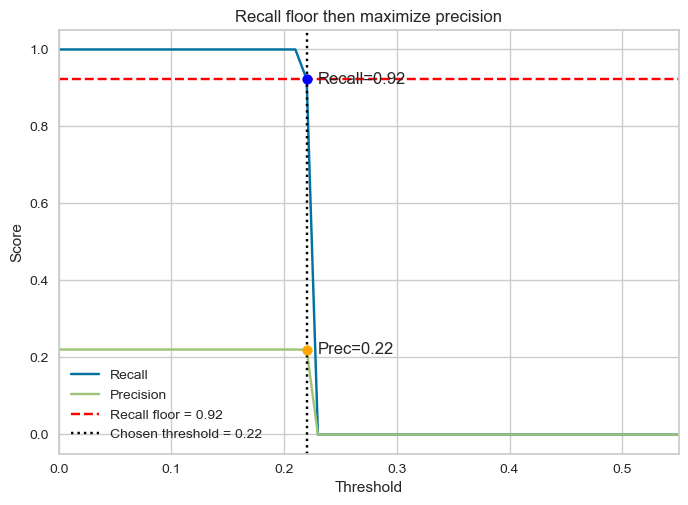

\n2. Cumulative Recall vs. Number of Alerts


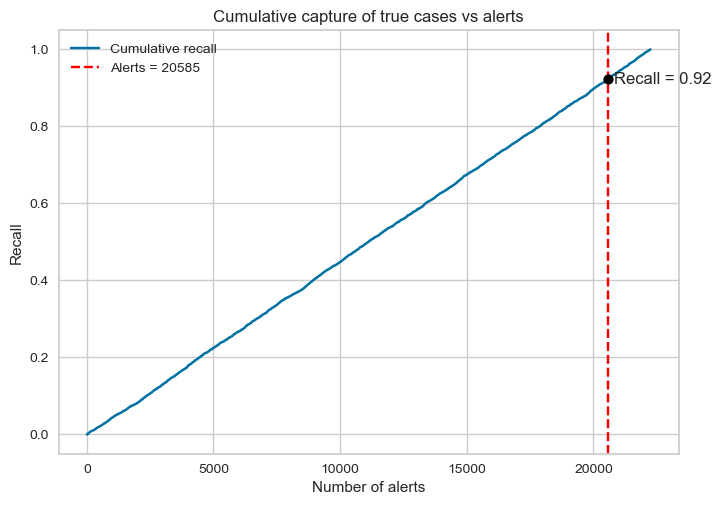

\n3. Top 30 Highest-Risk Patients View


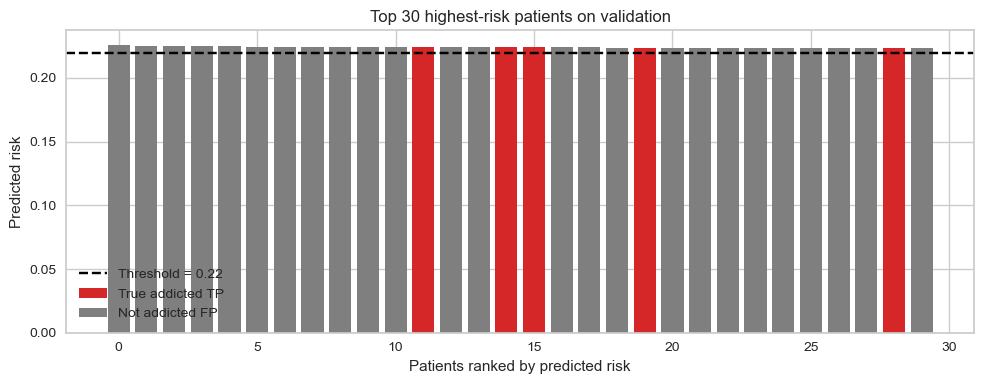

Final Calibrated Model on Test Set
PR AUC: 0.219
ROC AUC: 0.498
Prevalence p = 0.221  |  PR AUC lift = 0.99× over baseline


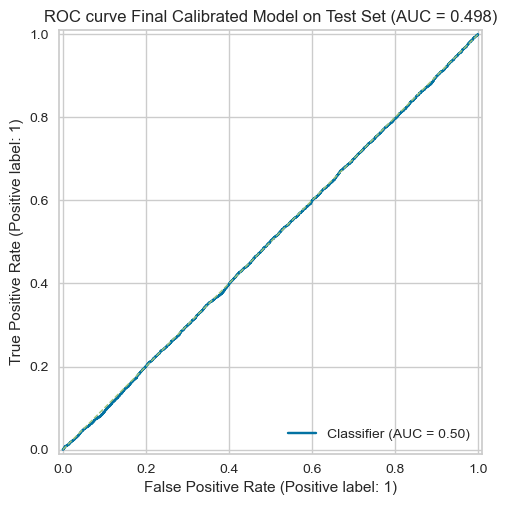

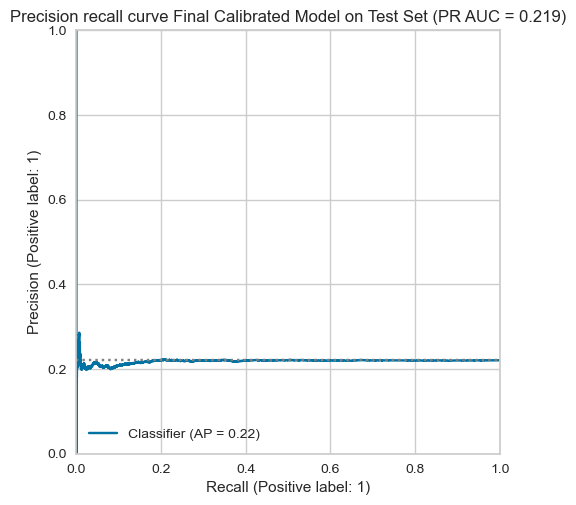

{'name': 'Final Calibrated Model on Test Set',
 'roc_auc': 0.49810865461449705,
 'pr_auc': 0.218742005312123,
 'prevalence': 0.22062921348314607,
 'lift': 0.9914462453034706}

In [ ]:
from sklearn.metrics import recall_score

# --- Final Threshold Selection (from your "Recall Floor" policy) ---
# This ensures THR is set to the value derived from the validation set analysis.
THR = thr_rec

print(f"--- Visualizing Final Performance on Test Set at Threshold = {THR:.2f} ---")

# --- Step 1: Get scores and metrics on the TEST set ---
y_score_test = positive_scores(calibrated_clf, X_test)

# For the first plot, we need the actual recall achieved on the test set by our threshold.
y_pred_test = (y_score_test >= THR).astype(int)
recall_at_thr_test = recall_score(y_test, y_pred_test)


# --- Step 2: Generate the plots sequentially using your utils functions ---

# Plot 1: Recall Floor Curves
print("\\n1. Precision-Recall Curve with Final Threshold and Resulting Recall")
plot_recall_floor_curves(y_true=y_test,
                         y_score=y_score_test,
                         recall_floor=recall_at_thr_test,
                         chosen_threshold=THR)

# Plot 2: Cumulative Recall vs. Alerts
print("\\n2. Cumulative Recall vs. Number of Alerts")
plot_cumulative_recall_at_threshold(y_true=y_test,
                                     y_score=y_score_test,
                                     chosen_threshold=THR)

# Plot 3: Top-k Patient Prioritization
print("\\n3. Top 30 Highest-Risk Patients View")
plot_topk_at_threshold(y_true=y_test,
                       y_score=y_score_test,
                       chosen_threshold=THR,
                       top_k=30)

# Generate the report and plots for the final model on the test set
auc_report(y_true=y_test,
           y_score=y_score_test,
           name="Final Calibrated Model on Test Set")

# References

